In [51]:
import numpy as np  # Importa la biblioteca NumPy para operaciones matemáticas y manipulación de arrays
import pandas as pd  # Importa la biblioteca pandas para manipulación y análisis de datos
import matplotlib.pyplot as plt  # Importa Matplotlib para crear visualizaciones y gráficos
from sklearn.cluster import KMeans  # Importa la clase KMeans del módulo de clustering de scikit-learn para realizar agrupamiento
from sklearn.decomposition import PCA  # Importa PCA (Análisis de Componentes Principales) para reducción de dimensionalidad

In [52]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSLo2NoEd47ZPZnEeDQBO95NHxvMsUi7YG4nH9DEiDfMJIV2q5Qk0fPQX5J10ClRB7ixPrCbfkTHcTh/pub?output=csv "  # URL del archivo CSV en Google Sheets
data = pd.read_csv(url)  # Lee el archivo CSV desde la URL y lo carga en un DataFrame de pandas llamado 'data'

In [53]:
# Definir las columnas de interés
columnas_objetivo = ['Name', 'OVR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY',  # Lista de columnas que se desean conservar
                     'Acceleration', 'Sprint Speed', 'Positioning', 'Finishing',
                     'Shot Power', 'Long Shots', 'Volleys', 'Penalties',
                     'Vision', 'Crossing', 'Free Kick Accuracy', 'Short Passing',
                     'Long Passing', 'Curve', 'Dribbling', 'Agility',
                     'Balance', 'Reactions', 'Ball Control', 'Composure',
                     'Interceptions', 'Heading Accuracy', 'Def Awareness',
                     'Standing Tackle', 'Sliding Tackle', 'Jumping',
                     'Stamina', 'Strength', 'Aggression', 'Weak foot',
                     'Skill moves', 'Age', 'GK Diving', 'GK Handling',
                     'GK Kicking', 'GK Positioning', 'GK Reflexes',
                     'Preferred foot', 'Nation', 'Position']  # Lista de columnas a conservar

columnas = data.columns  # Obtiene todas las columnas del DataFrame 'data'

# Iterar sobre las columnas
for col in columnas:
    if col not in columnas_objetivo:  # Si la columna no está en la lista de objetivos
        data.drop(col, axis=1, inplace=True)  # Elimina la columna del DataFrame
    else:
        data[col] = data[col]  # Si está en la lista, simplemente re-asigna (esto no cambia nada)

In [54]:
# Imputar datos faltantes para las categorías de GK cambiando NaN por 0
gk_columns = ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']  # Lista de columnas relacionadas con el portero
data[gk_columns] = data[gk_columns].fillna(0)  # Reemplaza los valores NaN en las columnas de GK con 0

In [55]:
### Ahora extraeremos los datos
X = data.iloc[:, 1:-1].values  # Extrae todos los valores del DataFrame 'data', excluyendo la primera columna (índice 0) y la última (la variable objetivo)

In [56]:
### Codificar el pie preferido como variable numérica
from sklearn.preprocessing import LabelEncoder  # Importa la clase LabelEncoder del módulo de preprocesamiento de scikit-learn

# Crear el codificador
le = LabelEncoder()  # Instancia el codificador de etiquetas

# Codificar la penúltima columna (Preferred foot)
X[:, -2] = le.fit_transform(X[:, -2])  # Aplica la codificación a la columna del pie preferido (penúltima columna) y reemplaza los valores originales

# Codificar la última columna (Nation)
X[:, -1] = le.fit_transform(X[:, -1])  # Aplica la codificación a la columna de la nacionalidad (última columna) y reemplaza los valores originales

In [57]:
df = pd.DataFrame(X)  # Crea un DataFrame de pandas a partir de la matriz X

for col in df.columns:  # Itera sobre cada columna en el DataFrame
    # Convertir a numérico, forzando errores a NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convierte la columna a numérico; cualquier error se convierte en NaN

In [58]:
X = df.values  # Extrae los valores del DataFrame como una matriz de numpy

In [59]:
from sklearn.impute import SimpleImputer

# Inicializar el imputador para manejar valores faltantes, usando la mediana como estrategia
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X)  # Ajustar el imputador a los datos existentes
X = imputer.transform(X)  # Imputar los valores faltantes en X

In [60]:
X_ = X[:,:-1]  #### Eligiendo todos los datos, excepto la nacionalidad

In [61]:
import random  # Importar la biblioteca para generar números aleatorios

In [62]:
from sklearn.decomposition import PCA
X_ = X[:, :-1]  # Seleccionar todas las columnas menos la última
# Crear un objeto PCA y ajustar los datos
pca = PCA(n_components=3)  # Queremos las tres primeras componentes principales
X_pca = pca.fit_transform(X_)  # Transformar los datos a las nuevas componentes

In [63]:
# Definimos la distancia Euclideana
def distancia_euclideana(x, c):
    return np.sqrt(np.sum((x - c) ** 2))  # Calcula la distancia Euclideana entre dos puntos

# Paso 1: Número de clusters
k = 4  # Elegimos 4 clusters basado en la heurística y el método del codo

# Paso 2: Elección de centroides
dimension = X_.shape[0]  # Número total de jugadores (filas del DataFrame)
centroids = X_[random.sample(range(dimension), k)]  # Seleccionamos k centroides aleatoriamente
print(data.iloc[centroids[:, 0], 0])  # Imprime el nombre del primer centroide
print(data.iloc[centroids[:, 1], 0])  # Imprime el nombre del segundo centroide
print(data.iloc[centroids[:, 2], 0])  # Imprime el nombre del tercer centroide

# Almacenamiento de etiquetas
clusters_manuales = np.zeros(dimension)  # Vector inicial para almacenar etiquetas de clusters
# Almacenamiento de distancias
distancias = np.zeros((dimension, k))  # Matriz para almacenar distancias entre puntos y centroides

# Paso 3: Implementación del método y criterios de convergencia
tol = 1e-6  # Tolerancia para el cambio en los centroides
error = 100  # Inicializa el error en un valor alto para entrar al bucle

# Repetir hasta que los centroides dejen de moverse significativamente
while error > tol:
    # Asignación de puntos a los clusters más cercanos
    for i in range(dimension):  # Iterar sobre cada jugador
        for j in range(k):  # Iterar sobre cada centroide
            distancias[i, j] = distancia_euclideana(X_[i], centroids[j])  # Calcular distancia
        clusters_manuales[i] = np.argmin(distancias[i])  # Asignar el cluster más cercano

    # Almacenar los centroides previos antes de actualizarlos
    centroids_prev = np.copy(centroids)  # Hacer una copia de los centroides actuales

    # Actualizar centroides
    for l in range(k):  # Iterar sobre los clusters
        puntos_cluster = X_[clusters_manuales == l]  # Filtrar puntos del cluster l

        # Si el cluster no está vacío, recalcula el centroide
        if len(puntos_cluster) > 0:
            centroids[l] = np.mean(puntos_cluster, axis=0)  # Promediar puntos del cluster
        else:
            print(f"Cluster {l} vacío, reasignando centroide aleatoriamente")  # Mensaje si el cluster está vacío
            centroids[l] = X_[np.random.choice(dimension)]  # Asigna un nuevo centroide aleatorio

    # Calcular el error como el cambio promedio en los centroides
    error = np.mean([distancia_euclideana(centroids[l], centroids_prev[l]) for l in range(k)])  # Calcula el error
    print(error)  # Imprime el error para monitorear la convergencia

63      Manuel Neuer
59     Karim Benzema
70    Alexander Isak
82       Cole Palmer
Name: Name, dtype: object
66     Ronald Araujo
72      Jules Koundé
75    James Maddison
46           Gabriel
Name: Name, dtype: object
62       Unai Simón
48          Rodrygo
51         Grimaldo
67    Julian Brandt
Name: Name, dtype: object
48.140602793629114
12.45014620249108
8.41651491938916
5.525649396283088
3.5745767653799954
2.459484226947711
1.7154122784401293
1.2450887534911046
0.7886481424152123
0.5991209313068613
0.4827123067891602
0.3141036113462866
0.2105255734771801
0.18674001491996012
0.12242188005236482
0.062665840763293
0.04400504711017921
0.050564272884843234
0.04011592471073672
0.033143729701198436
0.020109398013983502
0.014388315301009025
0.0


In [64]:
clusters_manuales = clusters_manuales.astype(int)  # Convierte las etiquetas de clusters a tipo entero

In [65]:
import seaborn as sns

def graficar_clusters_PCA2D(clusters, metodo, centroids):
    # Crear un gráfico de dispersión 2D usando las dos primeras componentes
    plt.figure(figsize=(10, 6))  # Definir el tamaño de la figura
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],  # Graficar las dos primeras componentes
                    hue=clusters, palette='cividis',  # Colorear por clusters
                    alpha=0.6, s=100)  # Ajustar la transparencia y el tamaño de los puntos
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, label='centroides')  # Graficar los centroides
    plt.title(f'Visualización 2D de la Clusterización (PCA) {metodo}', fontsize=16)  # Título del gráfico
    plt.xlabel('Componente Principal 1')  # Etiqueta del eje X
    plt.ylabel('Componente Principal 2')  # Etiqueta del eje Y
    plt.grid(True)  # Activar la cuadrícula
    plt.grid(linestyle='-', alpha=0.5)  # Personalizar la cuadrícula
    plt.legend(title='Cluster')  # Leyenda del gráfico
    plt.show()  # Mostrar el gráfico

In [66]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def graficar_clusters_PCA3D(clusters, metodo):
    # Crear el gráfico 3D
    fig = plt.figure(figsize=(15, 8))  # Definir el tamaño de la figura
    ax = fig.add_subplot(111, projection='3d')  # Añadir un subplot 3D

    # Graficar los puntos con borde blanco
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  # Graficar las tres componentes principales
                         c=clusters, cmap='cividis', s=100,  # Color por clusters, con tamaño de puntos
                         edgecolor='white', alpha=0.6)  # Bordes blancos y transparencia

    # Etiquetas de los ejes y título
    ax.set_title(f'Visualización 3D de la Clusterización (PCA) {metodo}', fontsize=16)  # Título del gráfico
    ax.set_xlabel('Componente Principal 1')  # Etiqueta del eje X
    ax.set_ylabel('Componente Principal 2')  # Etiqueta del eje Y
    ax.set_zlabel('Componente Principal 3')  # Etiqueta del eje Z

    # Añadir la leyenda
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")  # Crear leyenda
    ax.add_artist(legend1)  # Añadir leyenda al gráfico

    # Mostrar el gráfico
    plt.show()  # Mostrar la visualización

In [67]:
centroids = np.array(centroids)  # Convertir los centroides a un arreglo numpy
centroids = pca.transform(centroids)  # Transformar los centroides a 3 dimensiones utilizando PCA

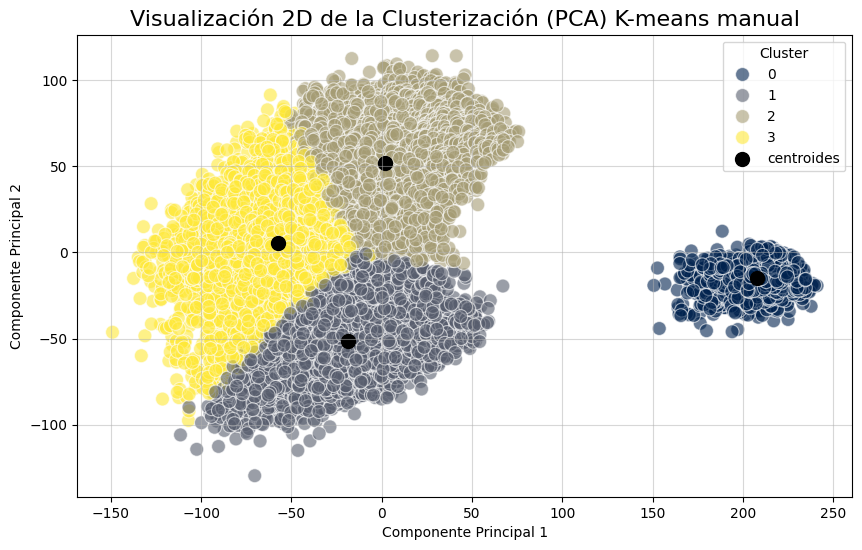

In [68]:
manual_2D = graficar_clusters_PCA2D(clusters_manuales, 'K-means manual', centroids)  # Graficar clusters manuales en 2D
manual_2D

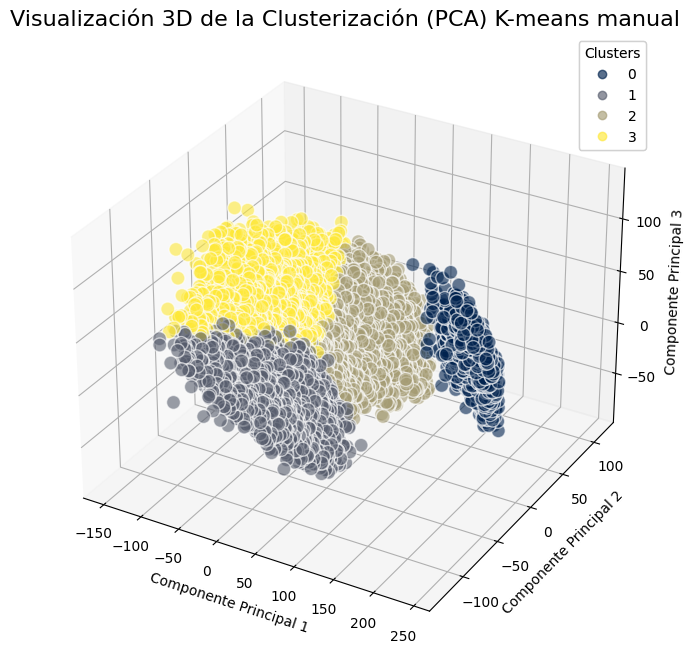

In [69]:
manual_3D = graficar_clusters_PCA3D(clusters_manuales, 'K-means manual')  # Graficar clusters manuales en 3D
manual_3D